In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import astropy.io.fits as pf
import xaosim as xs
from xaosim.pupil import HST_NIC1 as HST
from scipy.ndimage import rotate

from time import time as clock
import morphine
import xara

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")

bit = 32
# bit = 64

if bit == 64:
    print('64 bit enabled')
    from jax.config import config; config.update("jax_enable_x64", True)


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
PSZ     = 2048   # size of the array for the model
rad = 512
pmask  = HST(PSZ, rad, ang=45) # rotated!
limits = round(PSZ/2-rad*0.955),round(PSZ/2+rad*0.955)
pmask = pmask[limits[0]:limits[1],limits[0]:limits[1]]
# pmask = np.roll(
#         np.roll(pmask, int(-0.0 * rad), axis=1),
#         int(0.08 * rad), axis=0) # MASK SHIFT !!


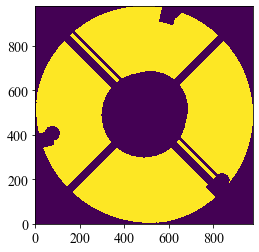

In [3]:
plt.imshow(pmask)

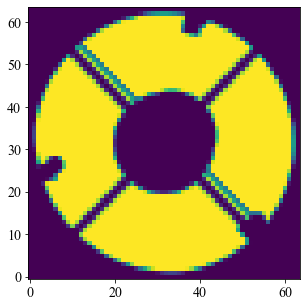

In [4]:
PSZ = 64 # size of the array for the model
rad = PSZ/2
# PSZ = rad*4 
PPSZ = PSZ*2

pdiam   = 2.4 #*0.955 # telescope diameter in meters
# pmask   = HST(PSZ, PSZ/2, mask="med")
oversample = 5

pmask  = HST(PPSZ*(2**oversample), (2**oversample)*PPSZ/4, ang=45) # rotated!

def half_bin(array):
    return (array[::2,::2] + array[1::2,::2] + array[::2,1::2] + array[1::2,1::2])/4.

for j in range(oversample):
    pmask = half_bin(pmask)
    
limits = int(PPSZ/2-rad),int(PPSZ/2+rad)
pmask = pmask[limits[0]:limits[1],limits[0]:limits[1]]
pmask = np.array(pmask)

ppscale = pdiam / (rad*2)


# -------------------------
#      simple plot
# -------------------------
f0 = plt.figure(0)
f0.clf()
ax = f0.add_subplot(111)
ax.imshow(pmask)
f0.set_size_inches(5,5, forward=True)

#f0.savefig("./imgs/HST/rotated_pupil.png")
# -------------------------



In [5]:
# pmask = pmask.T

In [6]:
pmask.shape

(64, 64)

In [7]:
hst = morphine.ArrayOpticalElement(opd=np.zeros_like(pmask),
                               transmission=np.array(pmask),
                               pixelscale=ppscale,
                               name='nicmos',planetype=1)
hst.pupil_diam = pdiam

In [8]:
# if you have an optimized model
# pmask = np.array(onp.loadtxt('opt_F170M.txt'))

In [9]:
WAVELENGTH = 1.90040e-6 # F190M
WAVELENGTH = 1.70579e-6 # F170M - from Frantz' numbers, slightly different from the published ones?
print(WAVELENGTH)
# WAVELENGTH = 1.08328e-6 # F110W - http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=HST&gname2=NICMOS1
RADIUS = pdiam/2. # meters
PIXSCALE = 0.0431 # arcsec / pix
NWAVES = 1.0
ISZ = 128
FOV = ISZ*PIXSCALE # arcsec
NPIX = 128#96

osys = morphine.OpticalSystem(npix=pmask.shape[0])
osys.add_pupil(hst)    
osys.pupil_diameter = pdiam
pscale = PIXSCALE
osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)  # image plane coordinates in arcseconds
osys.source_offset_r = 0*pscale
osys.source_offset_theta = 0

1.70579e-06


In [10]:
wf = osys.input_wavefront()

In [11]:
hst.pixelscale

0.0375

In [12]:
psf,intermediate = osys.propagate_mono(WAVELENGTH)

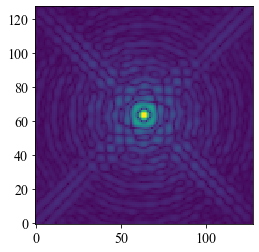

In [13]:
plt.imshow(psf.intensity**0.25)

In [14]:
ISZ

128

In [15]:
m2pix = xara.core.mas2rad(pscale*1000.) * ISZ / WAVELENGTH
print('m2pix =',m2pix)

m2pix = 15.679656440388843


In [16]:
u = np.linspace(-pdiam,pdiam,NPIX)
uu, vv = np.meshgrid(u,u)

In [17]:
dft1 = np.array(xara.core.compute_DFTM1(onp.array([uu.ravel(),vv.ravel()]).T,m2pix,psf.intensity.shape[0],offset=0.5))

In [18]:
# np.sqrt(dft1.shape[0]).astype('int')

In [19]:
def frantz_ft1(image,FF,norm=1):
    # norm is kpi.TRM.sum() / image.sum()
    myft_v = np.dot(FF,image.flatten())
    myft_v *= norm/image.sum()
    npix = np.sqrt(dft1.shape[0]).astype('int')
    return myft_v.reshape(npix,npix)

def frantz_ft1_short(image,FF,norm=1):
    # norm is kpi.TRM.sum() / image.sum()
    myft_v = np.dot(FF,image.flatten())
    myft_v *= norm/image.sum()
    return myft_v

In [20]:
cvis1 = frantz_ft1(psf.intensity,dft1)

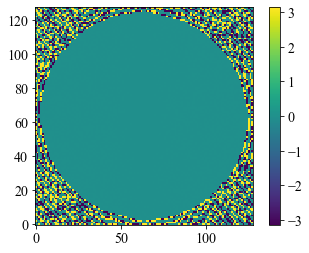

In [21]:
dummy = onp.copy(cvis1)#[32:96,32:96]
# plt.imshow(np.angle(cvis1))

plt.imshow(np.angle(dummy))
plt.colorbar()

## Non Zernike basis?

In [22]:
class mywavefront(morphine.ArrayOpticalElement):
    def __init__(self, wavelength, pupil, phasescreen, **kwargs):
        """ If your optic has adjustible parameters, then save them as attributes here """
        super().__init__()
        self.pupil = pupil
        self.wavelength = wavelength
        self.phasescreen = phasescreen

    def get_opd(self,wave):
        opd = self.phasescreen
        return opd

    def get_transmission(self, wave):
        transmission = self.pupil.get_transmission(wave)
        return transmission

    # behind the scenes morphine  will calculate:
    #    phasor = transmission = np.exp(1.j * 2 * np.pi / wave.wavelength * opd)


In [23]:
wfe = mywavefront(WAVELENGTH,osys.planes[0],np.zeros_like(pmask))

In [24]:
pupil = osys.planes[0]


In [25]:
osys = morphine.OpticalSystem(npix=PSZ)
osys.add_pupil(hst)    # pupil radius in meters
osys.pupil_diameter = pdiam

wf = osys.input_wavefront()
wfe = mywavefront(WAVELENGTH,osys.planes[0],np.zeros_like(wf.coordinates()[0]))
osys.add_pupil(wfe)
osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)

psf,intermediate = osys.propagate_mono(WAVELENGTH)

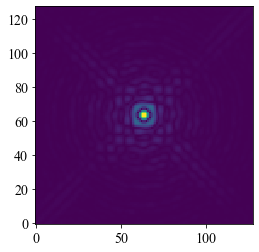

In [26]:
plt.imshow(psf.intensity**0.5)

## Now let's try to autodiff this

In [27]:
from jax.ops import index_update
    
def psf_from_phasescreen(phasescreen,wavel=WAVELENGTH):
    osys = morphine.OpticalSystem(npix=PSZ)
    osys.add_pupil(hst)
    osys.pupil_diameter = pdiam

    wf = osys.input_wavefront()
    wfe = mywavefront(wavel,osys.planes[0],phasescreen)
    osys.add_pupil(wfe)
    osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)

    psf,intermediate = osys.propagate_mono(wavel)
    return psf,osys

def end_to_end(phasescreen):
    psf, osys = psf_from_phasescreen(phasescreen)
    return frantz_ft1(psf.intensity,dft1)

def uv_phase(phasescreen):
    return np.angle(end_to_end(phasescreen))

zero_phase = np.zeros_like(wf.coordinates()[0])

output = uv_phase(zero_phase)
otf = end_to_end(zero_phase)
support = np.abs(otf) > 25.0e-4
pupil_trans = pmask.copy()

mid = np.round((NPIX+1)/2).astype('int')

half = onp.array(support).copy()
half[:,mid:] = 0

pupil_mask = (pupil_trans>0)

dft_short= np.array(xara.core.compute_DFTM1(onp.array([uu[half].ravel(),vv[half].ravel()]).T,m2pix,
                                            psf.intensity.shape[0],offset=0.5))
def screen_from_samples(samples):
    dummy = np.zeros_like(pmask) 
    return index_update(dummy,pupil_mask,samples)

def end_to_end_short(samples):
    phasescreen = screen_from_samples(samples)
    psf, osys = psf_from_phasescreen(phasescreen)
    return frantz_ft1_short(psf.intensity,dft_short)

def uv_phase_short(samples):
    return np.angle(end_to_end_short(samples))

In [28]:
m2pix

15.679656440388843

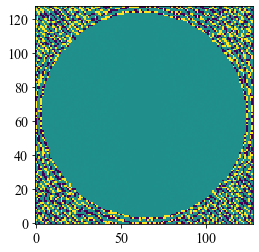

In [29]:
plt.imshow(output)

In [30]:
from jax import jacfwd, jacrev


In [31]:
%load_ext memory_profiler

In [32]:
# phasegrad = jacrev(uv_phase)

In [33]:
# %%memit 

# thisgrad = phasegrad(zero_phase)
# print(thisgrad.sum())


In [34]:
# phasegrad = jacfwd(uv_phase)
phasegrad_short = jacfwd(uv_phase_short)

In [35]:
# %%memit 
# time = clock()
# thisgrad = phasegrad(zero_phase)
# print(thisgrad.sum())
# print('Time taken:',(clock()-time)/60.,'min')

In [36]:
zero_pupil = np.zeros(np.sum(pmask>0))
print(zero_pupil.shape)
end_to_end_short(zero_pupil)

(2496,)


DeviceArray([0.00302827+1.8251305e-10j, 0.00364022+3.3824171e-10j,
             0.00417886-5.7539018e-10j, ..., 0.00606829-1.1021892e-10j,
             0.00596556-4.3814982e-10j, 0.00576527+1.1983048e-09j],            dtype=complex64)

In [37]:
%%memit 
time = clock()
thisgrad = phasegrad_short(np.zeros(np.sum(pmask>0)))
print(thisgrad.sum())
print('Time taken:',(clock()-time)/60.,'min')

1024.0
Time taken: 6.464753297964732 min
peak memory: 4468.32 MiB, increment: 1519.34 MiB


In [38]:
thisgrad.shape

(5447, 2496)

In [39]:
# transfer_martinache = thisgrad[:,:,support>0][pupil_trans==1,:].T
transfer = thisgrad[:,1:] # one free phase

In [40]:
print(transfer.shape)

(5447, 2495)


In [41]:
print(pupil_mask.shape)

(64, 64)


In [42]:
print(transfer)

[[-7.70471338e+03 -4.68101611e+03  1.07246545e+03 ...  8.43373516e+04
   3.34466328e+04  4.04490776e+01]
 [-9.16213770e+03 -1.34784229e+04 -5.19346240e+03 ...  6.94838047e+04
   2.79998008e+04  3.37388992e+01]
 [-7.70169043e+03 -1.67589805e+04 -1.55858213e+04 ...  6.14823711e+04
   2.43759629e+04  2.87947102e+01]
 ...
 [ 5.08018945e+03  1.05941670e+04  1.46204229e+04 ... -4.04426562e+04
  -1.47512705e+04 -1.66596069e+01]
 [ 5.12296533e+03  1.12143916e+04  1.46558848e+04 ... -4.31970078e+04
  -1.64264863e+04 -1.81137638e+01]
 [ 5.52284521e+03  1.14534707e+04  1.44566660e+04 ... -4.42017148e+04
  -1.78981445e+04 -2.05082741e+01]]


In [43]:
np.sum(pupil_mask)

DeviceArray(2496, dtype=int32)

In [44]:
%%time
u1, s1, v1 = np.linalg.svd((transfer.T),full_matrices=True)

CPU times: user 87.6 ms, sys: 2.18 ms, total: 89.8 ms
Wall time: 88.2 ms


In [45]:
# s1[6000]/s1[0]

In [46]:
 u1.shape, v1.shape

((2495, 2495), (5447, 5447))

In [47]:
np.sum((s1/s1[0])>5e-8)


DeviceArray(1639, dtype=int32)

In [48]:
first_k = np.min(np.where(s1/s1[0] == max(set(s1/s1[0]), key=list(s1/s1[0]).count)))

In [49]:
nbuv = np.sum(half>0)
npupil = np.sum(pupil_trans.ravel()>0.)
nkphi = nbuv-first_k
neig = first_k

print('Summary of properties')
print('---------------------------------------------------------------')
print('- %d sub-apertures' % npupil)
print('- %d distinct baselines' % nbuv)
print('- %d Ker-phases (%.1f %% target phase information recovery)' % (nkphi, 100*nkphi/nbuv))
print('- %d Eig-phases (%.1f %% wavefront information recovery)' % (neig,100*neig/npupil))
print('---------------------------------------------------------------')


Summary of properties
---------------------------------------------------------------
- 2496 sub-apertures
- 5447 distinct baselines
- 3795 Ker-phases (69.7 % target phase information recovery)
- 1652 Eig-phases (66.2 % wavefront information recovery)
---------------------------------------------------------------


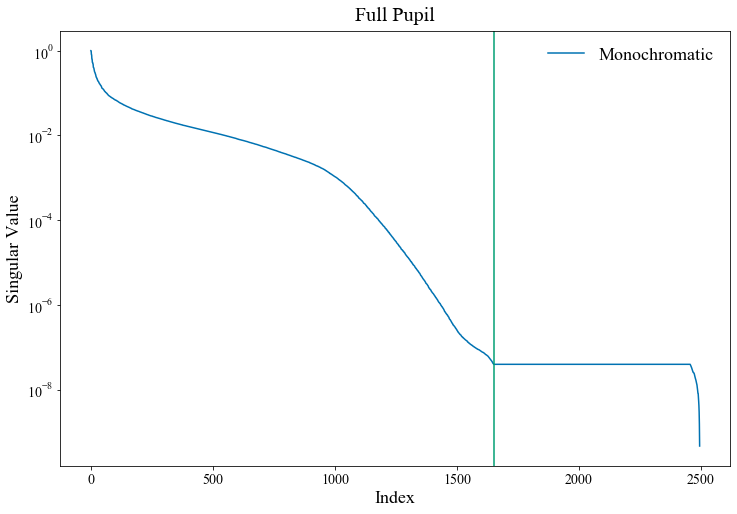

In [50]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1/s1[0],label='Monochromatic')
plt.axvline(first_k,color=colours[1])
# plt.plot(broadband['S1'],label='Broadband')
# plt.plot(corona['S1'],label='Lyot Coronagraph')
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
plt.title('Full Pupil',y=1.01,fontsize=20)
plt.legend(fontsize=18,frameon=False)
# plt.savefig('kerphi_singular.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/hst_kerphi_singular.pdf',bbox_inches='tight')

In [51]:
u1.shape, v1.shape

((2495, 2495), (5447, 5447))

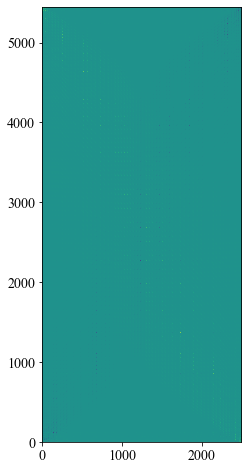

In [52]:
fig = plt.figure(figsize=(12.0,8.0))
plt.imshow((transfer),interpolation=None)

In [53]:
kernel = v1[(first_k+1):,:]
null = np.dot(kernel,transfer)

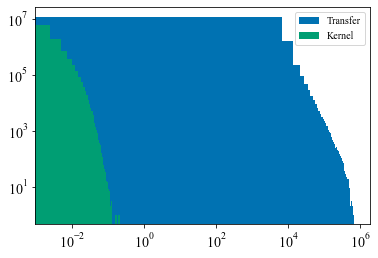

In [54]:
plt.hist(np.abs(transfer.ravel()),bins=100,label='Transfer');
plt.hist(np.abs(null.ravel()),bins=100,label='Kernel');

plt.xscale('log')
plt.yscale('log')
plt.legend()

### Verify this is a transfer matrix

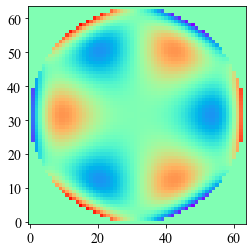

In [55]:
NZ = 20

zernikes = morphine.zernike.zernike_basis(NZ,npix=PSZ,outside=0.0)
plt.imshow(zernikes[-3,:,:],cmap=phasemap)


Text(0.5, 1.0, 'Linear')

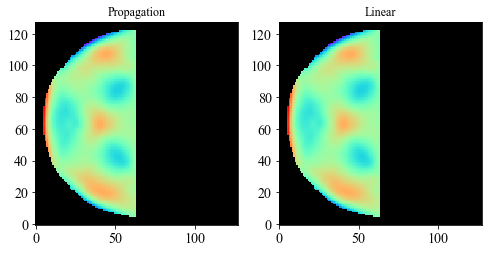

In [56]:
mode = 5e-9*zernikes[-3,:,:]
result = uv_phase(mode)
dummy = onp.array(result)
dummy[half!=1] = np.nan

linear = (onp.dot(transfer,mode[pupil_mask][1:]))
toy = onp.array(onp.nan*result)
toy[half==1.] = linear

fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].imshow(dummy,cmap=phasemap)
axes[0].set_title('Propagation')
axes[1].imshow(toy,cmap=phasemap)
axes[1].set_title('Linear')

### What do these kernel phase maps look like?

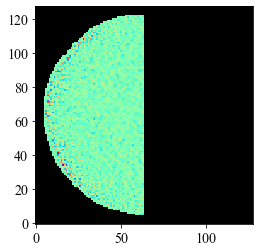

In [57]:
index = first_k+50

mode = 1.*onp.array(half)
mode[half==1.] = v1[index,:]
mode[half!=1.] = np.nan

plt.imshow(mode,cmap=phasemap)

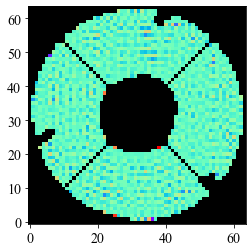

In [58]:
index = 1501

pupil_mode = 1.*onp.array(pupil_trans)
pupil_mode[pupil_mask] = onp.append([0],u1[:,index])
pupil_mode[~pupil_mask] = np.nan

plt.imshow(pupil_mode,cmap=phasemap)

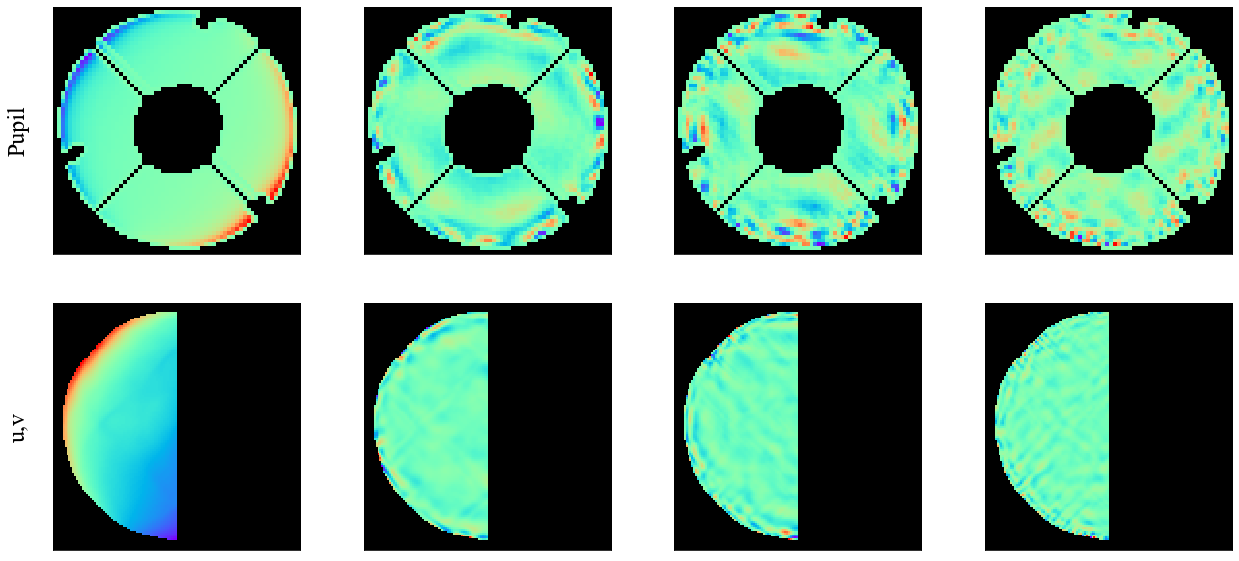

In [59]:
nsets = 4

fig, axes = plt.subplots(2,nsets,figsize=(8/3.*(nsets*2),10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_ylabel('Pupil',fontsize=24,labelpad=24)

axes[1,0].set_ylabel('u,v',fontsize=24,labelpad=24)

for j in range(nsets):
    mode = 1.*onp.array(half)
    mode[half>0] = v1[j*50,:]
    mode[half<=0] = np.nan

    axes[1,j].imshow(mode,cmap=phasemap)  
    
    wavefront = onp.ones_like(pupil_trans)
    wavefront[pupil_mask] *= onp.append([0],u1[:,j*50]) 
    wavefront[~pupil_mask] = np.nan
    axes[0,j].imshow(wavefront,cmap=phasemap)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/morphine/paper/hst_nonsingular_modes_mono.pdf',bbox_inches='tight')

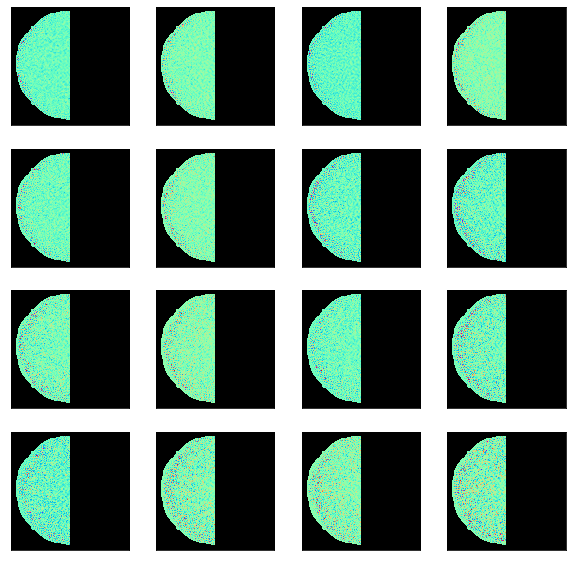

In [60]:
nsets = 4

fig, axes = plt.subplots(nsets,nsets,figsize=(10,10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

for j, axis in enumerate(axes.ravel()):
    mode = 1.*onp.array(half)
    mode[half==1.] = v1[j*50+first_k,:]
    mode[half<1.] = np.nan

    axis.imshow(mode,cmap=phasemap)  
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/morphine/paper/hst_kernel_modes_mono.pdf',bbox_inches='tight')

### Now can we save this as a KPI?

In [61]:
x = np.linspace(-pdiam/2.,pdiam/2.,PSZ)
xx, yy = np.meshgrid(x,x)

mask = onp.array([xx[pupil_mask], yy[pupil_mask],(pupil_trans[pupil_mask])]).T

# u = np.linspace(-pdiam,pdiam,NPIX)
# uu, vv = np.meshgrid(u,u)

uv_samp = onp.array([uu[half==1.], vv[half==1.]]).T



In [62]:
onp.array([uu[half].ravel(),vv[half].ravel()]).T-uv_samp

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [63]:
np.sqrt((uv_samp**2).sum(axis=1)).max()/(pdiam)

DeviceArray(0.9378346, dtype=float32)

In [64]:
transfer.shape

(5447, 2495)

In [65]:
kernel

DeviceArray([[-1.19798142e-03, -3.02486424e-03,  1.41097307e-02, ...,
              -4.67728451e-03,  7.38223735e-03, -1.09373615e-03],
             [ 6.47781789e-03, -1.57624409e-02,  1.69567782e-02, ...,
              -2.21175514e-02,  1.73632707e-02, -1.06324200e-02],
             [ 2.83937063e-03, -7.01056374e-03,  2.10289750e-03, ...,
               6.89822482e-03,  7.01164780e-03, -1.08890412e-02],
             ...,
             [ 5.58113272e-04,  3.66941537e-03, -1.28550967e-02, ...,
               1.28785908e-01, -9.54547673e-02,  4.07683030e-02],
             [ 7.14143971e-03, -1.48386778e-02,  2.03724410e-02, ...,
              -1.04012296e-01,  1.17792577e-01, -8.32788050e-02],
             [-2.03632261e-03,  3.19545506e-05,  2.11521517e-02, ...,
               3.60137746e-02, -8.25289786e-02,  1.11057892e-01]],            dtype=float32)

In [81]:
 data = {'name'   : 'hstmorphine_%dbit_%dpix_H' % (bit,NPIX),
         'mask'   : mask.astype('float64'),
         'uv'     : uv_samp.astype('float64'),
         'TFM'    : transfer.astype('float64'),
         'KerPhi' : kernel.astype('float64'),
         'RED'    : otf[half==1.].astype('float64'),
         'support': half.astype('float64'),
         'dft': dft_short.astype('complex128')}

In [82]:
%%time
import gzip, pickle
savefile = 'hstmorphine_%dbit_%dpix_H.kpi.gz' % (bit,NPIX)
print('saving to %s' % savefile)
myf = gzip.GzipFile(savefile, "wb")
pickle.dump(data, myf, -1)
myf.close()
print('saved')

saving to hstmorphine_32bit_128pix_H.kpi.gz
saved
CPU times: user 31.8 s, sys: 2.55 s, total: 34.4 s
Wall time: 36.1 s


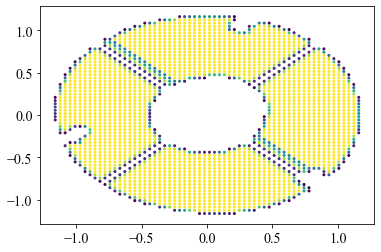

In [68]:
plt.scatter(mask[:,0],mask[:,1],c=mask[:,2],s=4)

In [69]:
# import gzip, pickle
# myf = gzip.GzipFile('hstmorphinefrantz_32bit_64pix.kpi.gz','r')
# test = pickle.load(myf)
# myf.close()

In [70]:
WAVELENGTH

1.70579e-06

In [80]:
dft_short.astype('complex128')

DeviceArray([[-0.99080783+0.13527682j, -0.99998856+0.00478774j,
              -0.99205774-0.12578325j, ..., -0.99205774+0.12578325j,
              -0.99998856-0.00478774j, -0.99080783-0.13527682j],
             [ 0.1402528 -0.9901157j ,  0.24016126-0.970733j  ,
               0.33758226-0.94129604j, ...,  0.33758226+0.94129604j,
               0.24016126+0.970733j  ,  0.1402528 +0.9901157j ],
             [ 0.9142523 +0.40514538j,  0.8823973 +0.47050503j,
               0.84587747+0.5333773j , ...,  0.84587747-0.5333773j ,
               0.8823973 -0.47050503j,  0.9142523 -0.40514538j],
             ...,
             [-0.97401124+0.22649954j, -0.98789436+0.1551281j ,
              -0.99655485+0.08293657j, ..., -0.99655485-0.08293657j,
              -0.98789436-0.1551281j , -0.97401124-0.22649954j],
             [ 0.04792042-0.9988512j ,  0.091446  -0.99581003j,
               0.13479748-0.99087316j, ...,  0.13479748+0.99087316j,
               0.091446  +0.99581003j,  0.04792042+0.9988

## Simulate some data

In [72]:
NZ = 20

zernikes = morphine.zernike.zernike_basis(NZ,npix=PSZ,outside=0.0)



In [73]:
coefficients_sequence = 25e-9*onp.random.randn(NZ)


hst_new = morphine.ArrayOpticalElement(opd=np.zeros_like(pmask),
                               transmission=np.array(pmask),
                               pixelscale=ppscale,
                               name='nicmos',planetype=1)
hst_new.pupil_diam = pdiam

aberrated = morphine.OpticalSystem(npix=PSZ)
aberrated.add_pupil(hst_new)    # pupil radius in meters
aberrated.pupil_diameter = pdiam

thinlens = morphine.ZernikeWFE(radius=pdiam/2., coefficients=coefficients_sequence, cached_zernikes=zernikes)
aberrated.add_pupil(thinlens)
aberrated.add_detector( pixelscale=PIXSCALE*2, fov_arcsec=64*PIXSCALE )

blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')

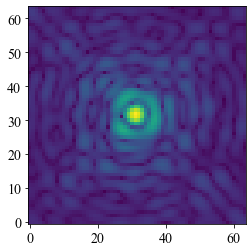

In [74]:
plt.imshow(blur.intensity**0.25,interpolation='none')

In [75]:
offset = 0.125

aberrated.source_offset_r = offset
aberrated.source_offset_theta = 86
tilted, intertilt = aberrated.propagate_mono(WAVELENGTH,normalize='first')
aberrated.source_offset_r = 0


In [76]:
contrast = 1./10.
science = contrast*tilted.intensity+blur.intensity

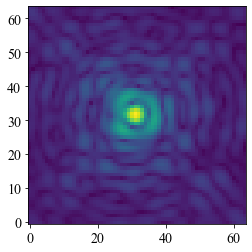

In [77]:
plt.imshow(science**0.25)

In [78]:
import pyfits
hdu = pyfits.PrimaryHDU(science)
hdulist = pyfits.HDUList([hdu])
hdulist.writeto('test_hst.fits',clobber=True)


In [79]:
# do a bunch of them

seps = [75,100,125,150]
cons = [10,25,50]
thetas = [0,86,180,270]

for sep in seps:
    for theta in thetas:
        aberrated.source_offset_r = sep/1000.
        aberrated.source_offset_theta = theta
        tilted, intertilt = aberrated.propagate_mono(WAVELENGTH,normalize='first')
        for con in cons:
            science = 1./con*tilted.intensity+blur.intensity
            
            hdu = pyfits.PrimaryHDU(science)
            hdulist = pyfits.HDUList([hdu])
            fname = 'test_hst_s%d_th%d_c%d.fits' % (sep,theta,con)
            hdulist.writeto(fname,clobber=True)
            print('Written to %s' % fname)


Written to test_hst_s75_th0_c10.fits
Written to test_hst_s75_th0_c25.fits
Written to test_hst_s75_th0_c50.fits
Written to test_hst_s75_th86_c10.fits
Written to test_hst_s75_th86_c25.fits
Written to test_hst_s75_th86_c50.fits
Written to test_hst_s75_th180_c10.fits
Written to test_hst_s75_th180_c25.fits
Written to test_hst_s75_th180_c50.fits
Written to test_hst_s75_th270_c10.fits
Written to test_hst_s75_th270_c25.fits
Written to test_hst_s75_th270_c50.fits
Written to test_hst_s100_th0_c10.fits
Written to test_hst_s100_th0_c25.fits
Written to test_hst_s100_th0_c50.fits
Written to test_hst_s100_th86_c10.fits
Written to test_hst_s100_th86_c25.fits
Written to test_hst_s100_th86_c50.fits
Written to test_hst_s100_th180_c10.fits
Written to test_hst_s100_th180_c25.fits
Written to test_hst_s100_th180_c50.fits
Written to test_hst_s100_th270_c10.fits
Written to test_hst_s100_th270_c25.fits
Written to test_hst_s100_th270_c50.fits
Written to test_hst_s125_th0_c10.fits
Written to test_hst_s125_th0_c25